# Setup og preprocessing

In [2]:
import pandas as pd
import numpy as np
import matplotlib as plt
import seaborn as sb

df = pd.read_csv("Arbejde.csv")

In [3]:
df.info()
df.head()

df['Completion time'] = pd.to_datetime(df["Completion time"])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3827 entries, 0 to 3826
Data columns (total 36 columns):
 #   Column                                                                                Non-Null Count  Dtype 
---  ------                                                                                --------------  ----- 
 0   ID                                                                                    3827 non-null   int64 
 1   Start time                                                                            3827 non-null   object
 2   Completion time                                                                       3827 non-null   object
 3   Email                                                                                 3827 non-null   object
 4   Name                                                                                  3827 non-null   object
 5   Type                                                                                  3827

/tmp/ipykernel_6695/4204815471.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Completion time'] = pd.to_datetime(df["Completion time"])


In [4]:
df = df[['Completion time', 'Type', 'Studieretning', 'Emne']]

start_date = '9/1/24 00:00:00'
end_date = '12/31/24 00:00:00'

start_date = pd.to_datetime(start_date)
end_date = pd.to_datetime(end_date)

mask = (df['Completion time'] >= start_date) & (df['Completion time'] <= end_date)
df_subset = df.loc[mask]

# Hvor mange søger vejledning i alt

<Axes: ylabel='Studieretning'>

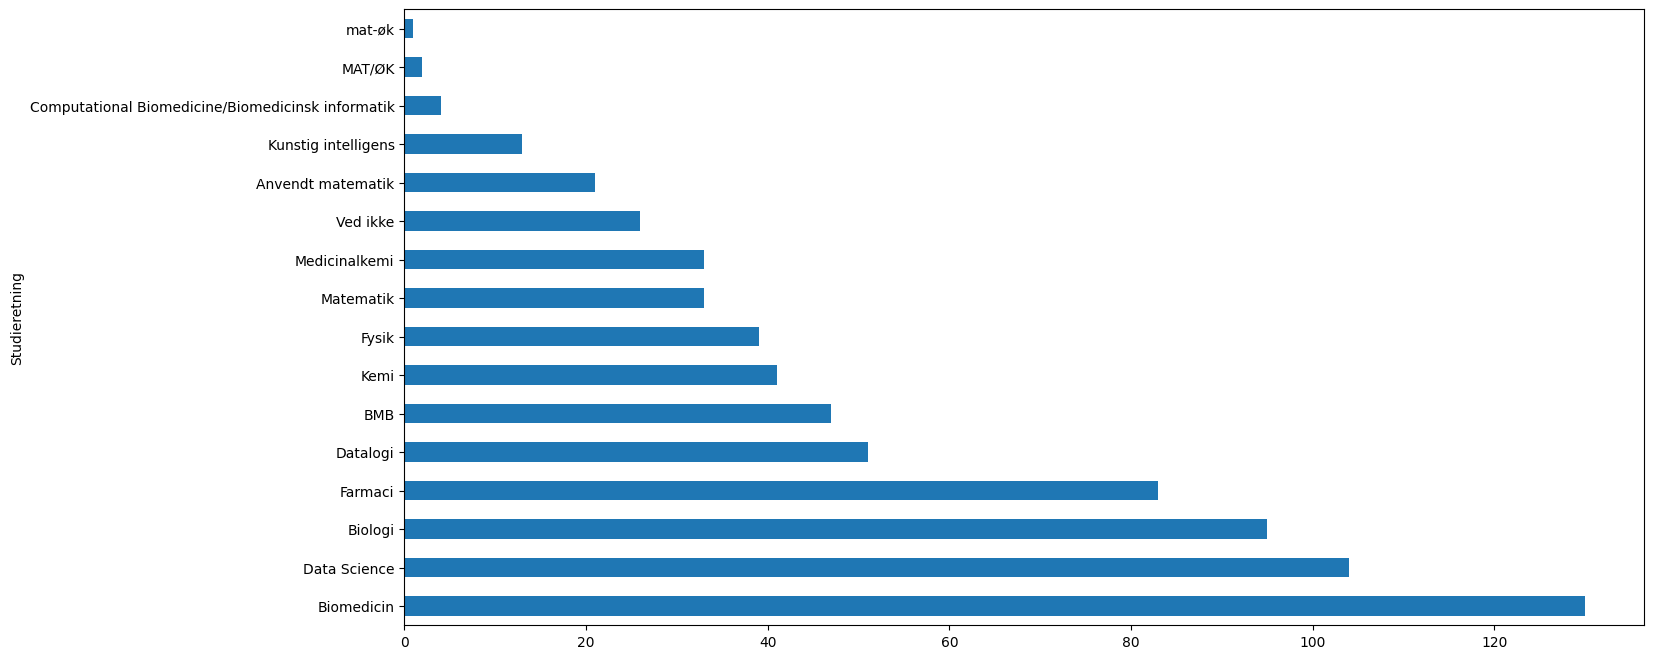

In [5]:
(df_subset['Studieretning']
 .value_counts()
 .plot(
     kind='barh',
     figsize=(16,8)
 ))

# Hvor mange søger vejledning per type

<Axes: ylabel='Type'>

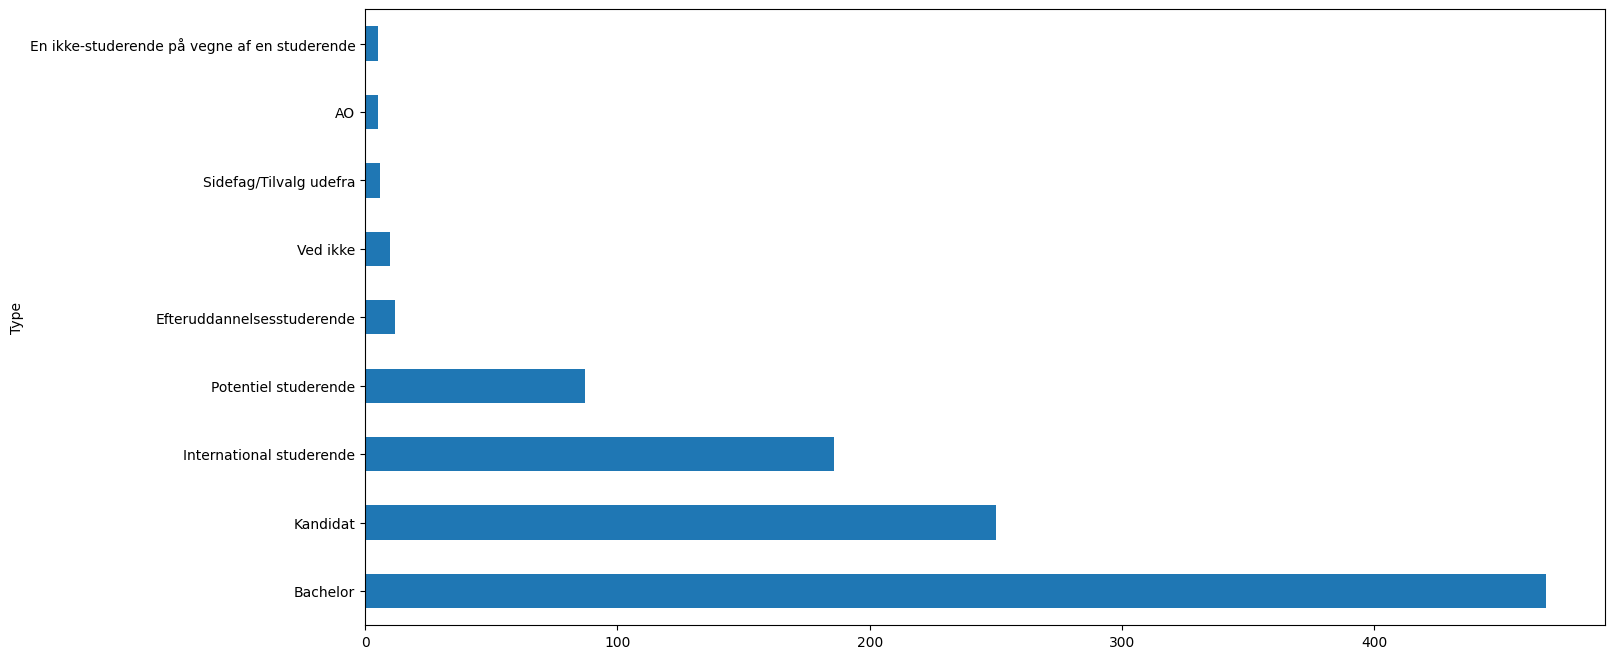

In [6]:
df_subset['Type'].value_counts().plot(kind='barh', figsize=(16,8))

# Hvor mange søger vejledning per studieretning per bachelor og kandidat

<Axes: title={'center': 'Bachelor'}, ylabel='Studieretning'>

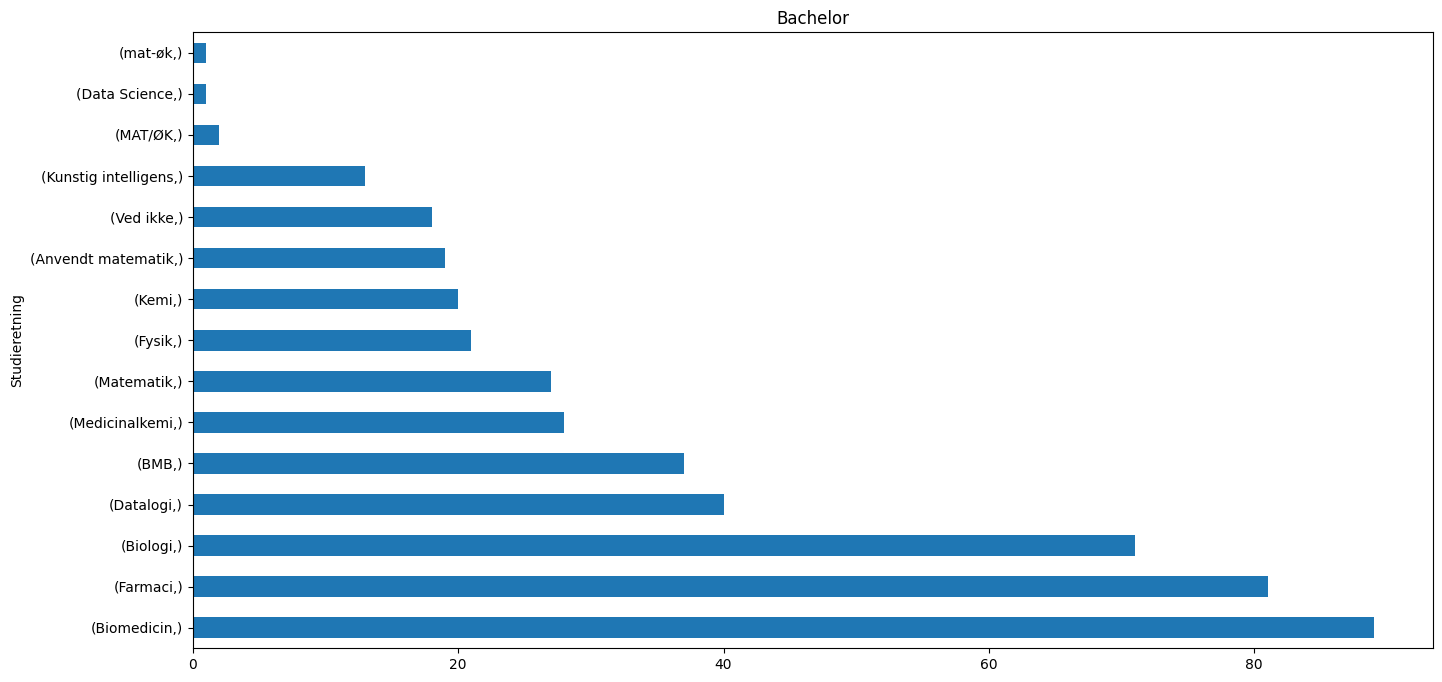

In [7]:
df_subset.loc[df['Type'] == 'Bachelor', ['Studieretning']].value_counts().plot(kind='barh', figsize=(16,8), title="Bachelor")

<Axes: title={'center': 'Kandidat'}, ylabel='Studieretning'>

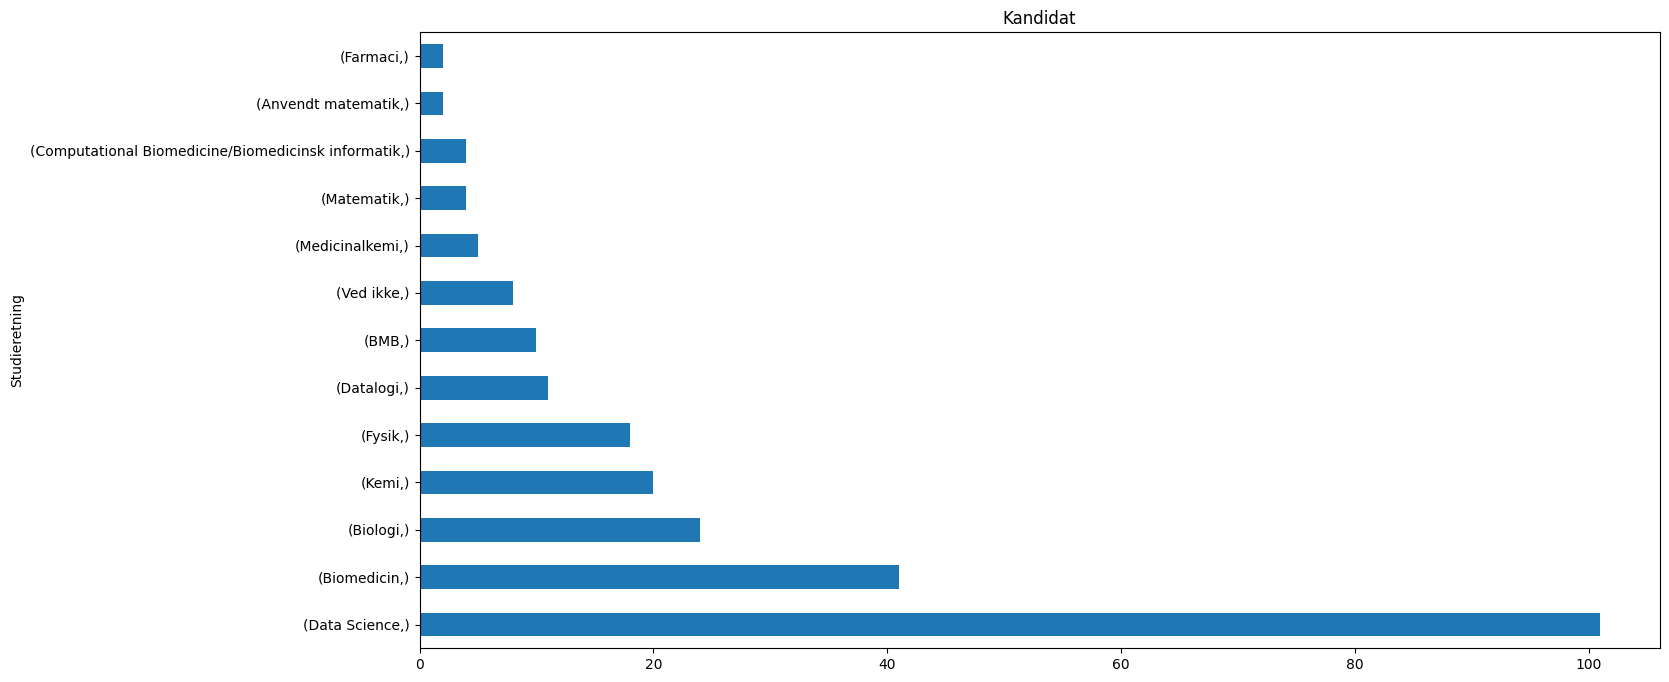

In [8]:
(df_subset
 .loc[df_subset['Type'] == 'Kandidat', ['Studieretning']]
 .value_counts()
 .plot(kind='barh',
       figsize=(16,8),
       title='Kandidat'))

# Hvor mange søger hjælp pr emne

In [9]:
df_exploded = df_subset.assign(Emne=df['Emne'].str.split(';')).explode('Emne')

print(df_exploded)

         Completion time      Type Studieretning                      Emne
2798 2024-09-02 09:06:03  Kandidat    Biomedicin            Valg undervejs
2798 2024-09-02 09:06:03  Kandidat    Biomedicin          Kursustilmelding
2798 2024-09-02 09:06:03  Kandidat    Biomedicin                          
2799 2024-09-02 09:06:19  Bachelor    Biomedicin          Kursustilmelding
2799 2024-09-02 09:06:19  Bachelor    Biomedicin                          
...                  ...       ...           ...                       ...
3824 2024-10-28 13:43:07  Kandidat    Biomedicin                          
3825 2024-10-28 13:44:50  Kandidat  Data Science            Valg undervejs
3825 2024-10-28 13:44:50  Kandidat  Data Science                          
3826 2024-10-29 09:31:59  Bachelor       Biologi  Dispensation (Husk note)
3826 2024-10-29 09:31:59  Bachelor       Biologi                          

[1966 rows x 4 columns]


In [10]:
df_exploded = df_exploded.loc[df_exploded['Emne'] != ""]

<Axes: ylabel='Emne'>

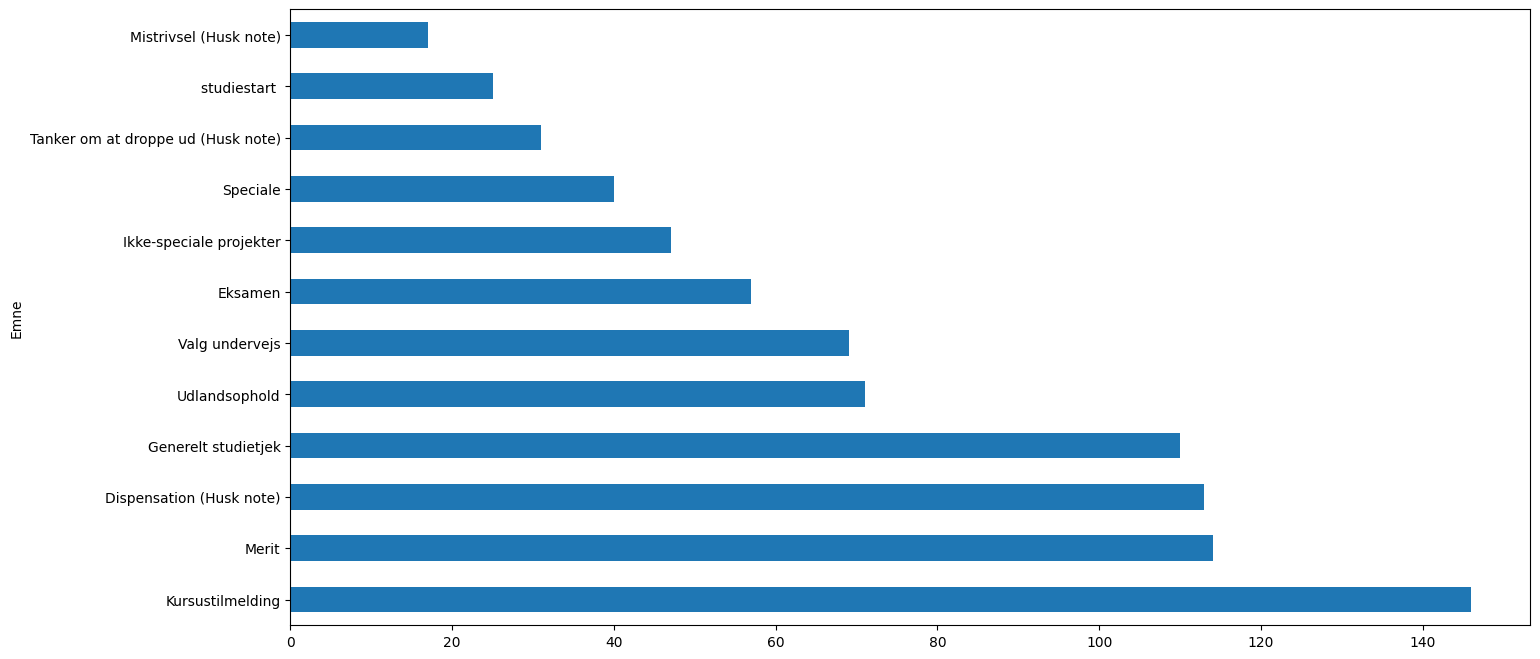

In [11]:
#(df_exploded['Emne'].value_counts()
 #.loc[lambda x: x > 10] # Filter alle større end 10
 #.index
 #.pipe(lambda frequent: df_exploded[df_exploded['Emne'].isin(frequent)])
 #['Emne'].value_counts()
 #.plot(kind='barh', figsize=(16,8)))


(df_exploded['Emne'].value_counts()
 .loc[lambda x: x>10]
 .plot(
     kind='barh',
     figsize=(16,8)
 ))


# Hvilken type emne er mest forkommende pr studieretning

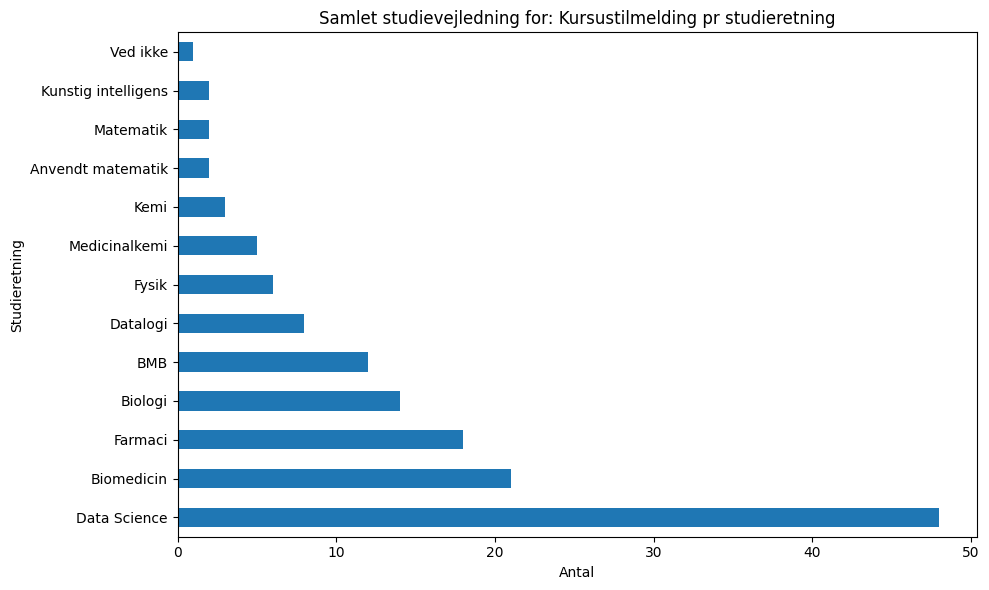

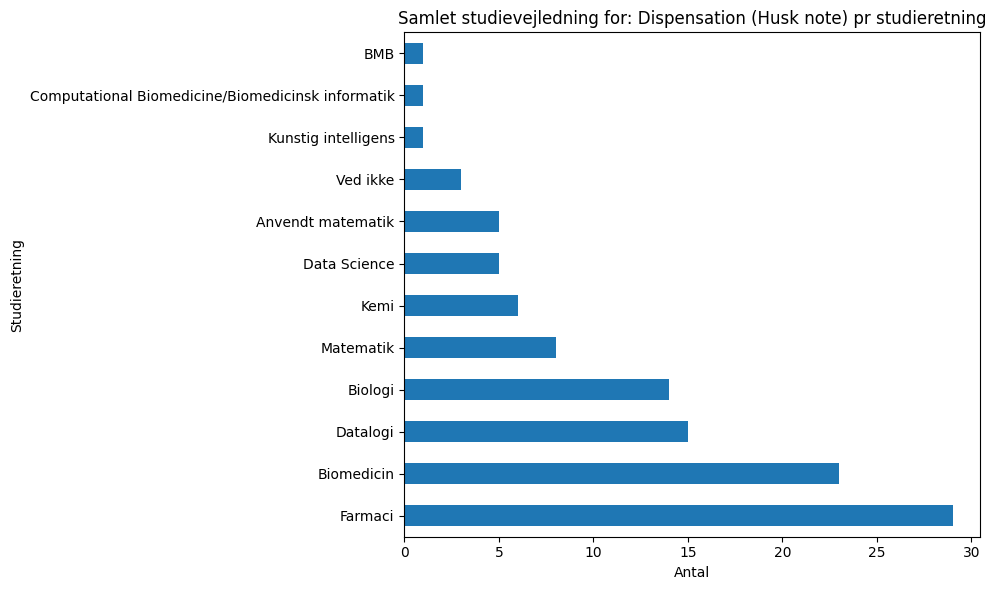

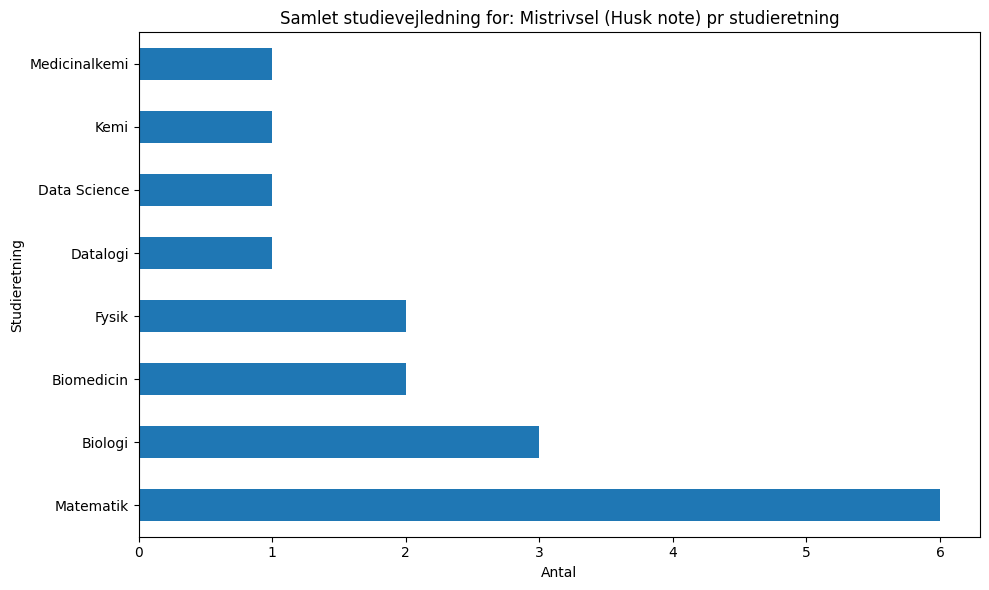

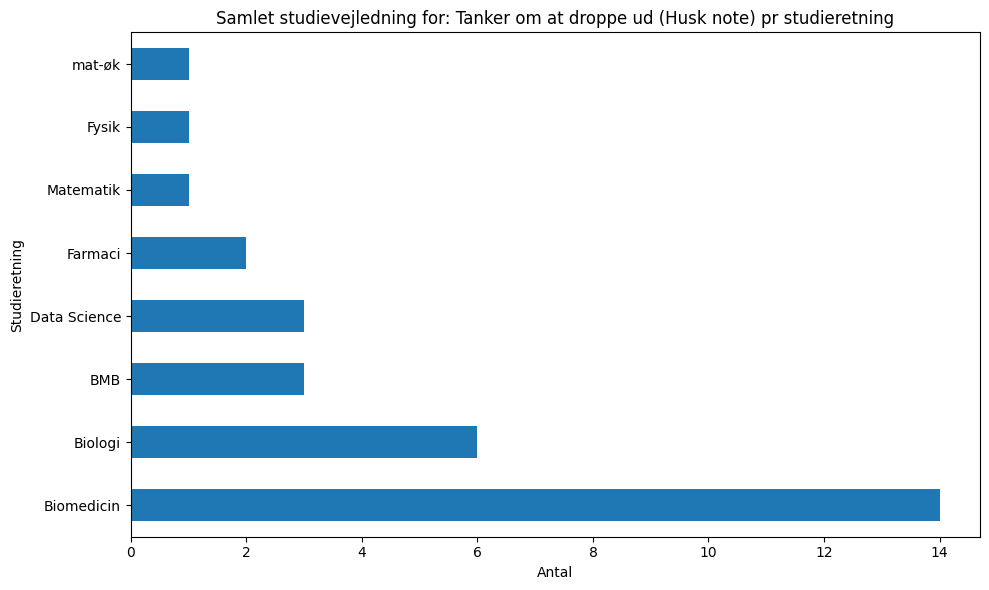

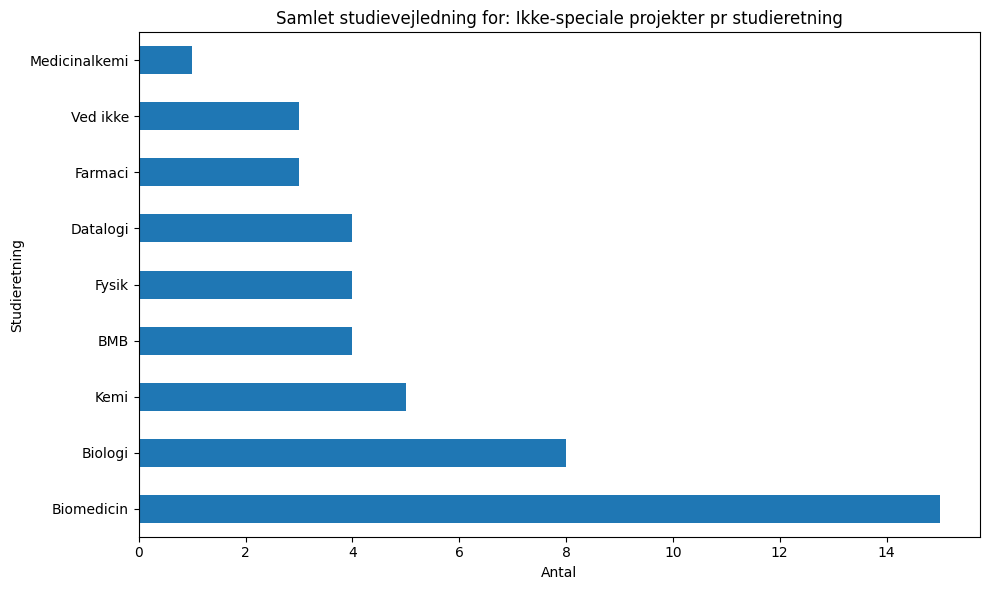

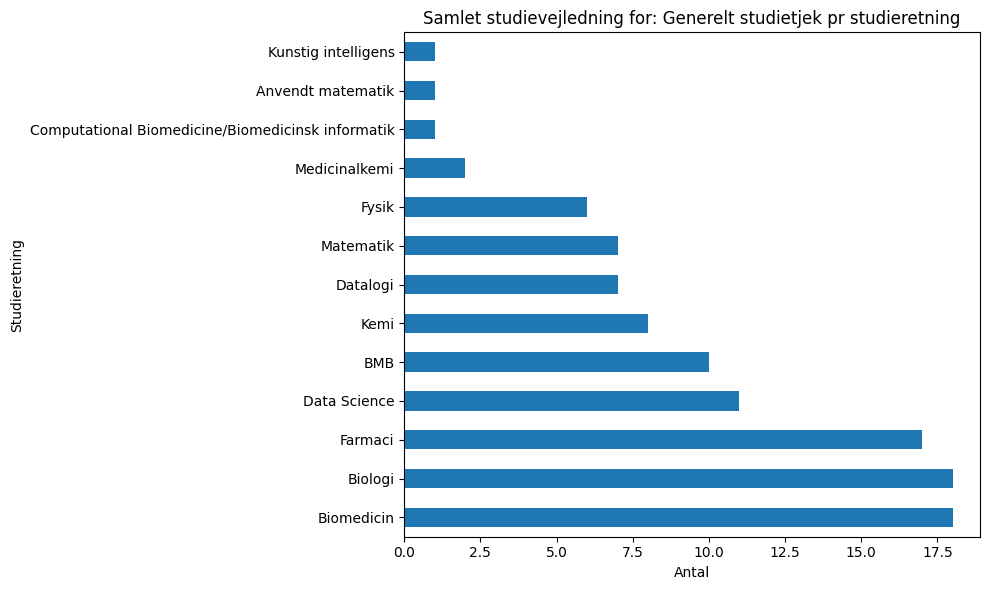

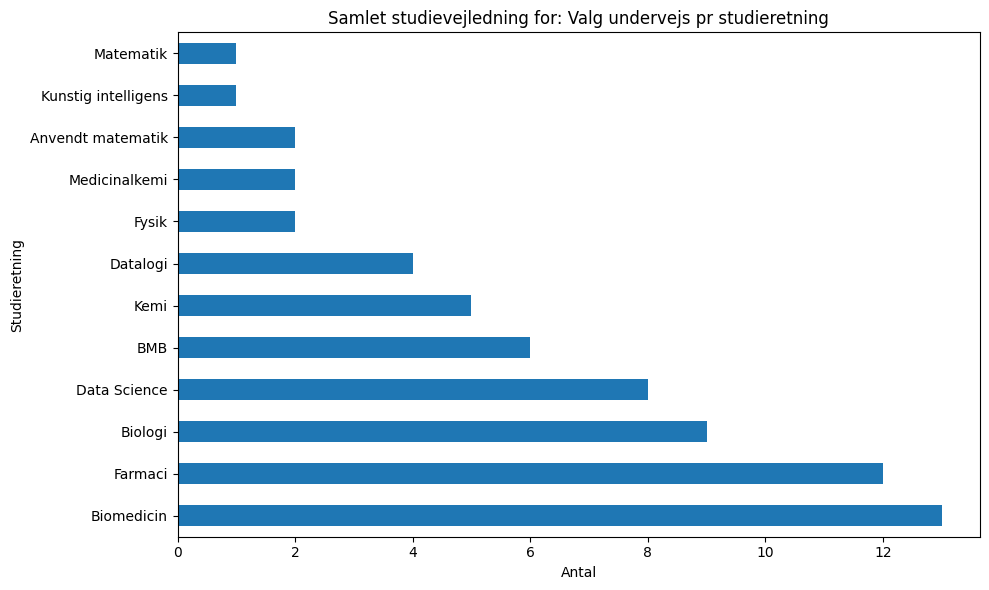

In [29]:
import matplotlib.pyplot as pyplt

def test(ds, tema):
    temp = ds[ds['Emne'] == tema]
    if not temp.empty:
        pyplt.figure(figsize=(10,6))
        temp['Studieretning'].value_counts().plot(kind='barh')
        pyplt.xlabel('Antal')
        pyplt.ylabel('Studieretning')
        pyplt.title(f"Samlet studievejledning for: {tema} pr studieretning")
        pyplt.tight_layout()
        pyplt.show()
    else:
        print(f"No data found for tema: {tema}")

tema_list = ['Kursustilmelding',
             'Dispensation (Husk note)',
             'Mistrivsel (Husk note)',
             'Tanker om at droppe ud (Husk note)',
             'Ikke-speciale projekter',
             'Generelt studietjek',
             'Valg undervejs']

for i in tema_list:
    test(df_exploded.copy(), i)

# Random stats

### Chi-square test

In [13]:
import scipy.stats as sc

In [37]:
data = df_exploded

studieretning = df_exploded['Studieretning'].unique()

    
def stats(data, tema, studie):
    # Creating a 2x2 table

    # number of rows where Emne == emne og Studieretning == Studieretning
    a = ((data['Emne'] == tema) & (data['Studieretning'] == studie)).sum()

    # Number of rows where emne == emne and studieretning != studieretning

    b = ((data['Emne'] == tema) & (data['Studieretning'] != studie)).sum()

    # number of rows where Emne != Emne and Studieretning == Studie
    c = ((data['Emne'] != tema) & (data['Studieretning'] == studie)).sum()

    # Number of rows where Emne != Emne and Studieretning != Studie
    d = ((data['Emne'] != tema) & (data['Studieretning'] != studie)).sum()

    return [[a, b],
            [c, d]]

for i in tema_list:
    print(f"Testing in {i}")
    for j in studieretning:
        results = stats(data, i, j)
        try:
            stat, p, dof, expected = sc.chi2_contingency(results)
            print(f"P-value: {p} for {i} in {j}")
        except ValueError as e:
            if "expected frequencies has a zero element" in str(e):
                print(f"Skipped {i} in {j} due to zero expected frequency")
            else:
                raise
    print("\n")


Testing in Kursustilmelding
P-value: 0.9689662126853349 for Kursustilmelding in Biomedicin
P-value: 0.8590089430823804 for Kursustilmelding in Medicinalkemi
P-value: 0.8776708785122322 for Kursustilmelding in Anvendt matematik
P-value: 0.9449610522637405 for Kursustilmelding in Fysik
P-value: 0.2651881757842699 for Kursustilmelding in Farmaci
P-value: 0.9577154109306353 for Kursustilmelding in Biologi
Skipped Kursustilmelding in nan due to zero expected frequency
P-value: 0.9988309349922543 for Kursustilmelding in Datalogi
P-value: 0.1234462494937032 for Kursustilmelding in BMB
P-value: 0.2619103892541594 for Kursustilmelding in Matematik
P-value: 0.2746630544321451 for Kursustilmelding in Kemi
P-value: 4.642004198064435e-19 for Kursustilmelding in Data Science
P-value: 0.7868419217369075 for Kursustilmelding in Computational Biomedicine/Biomedicinsk informatik
P-value: 0.30328536753489704 for Kursustilmelding in Ved ikke
P-value: 1.0 for Kursustilmelding in Kunstig intelligens
P-value